In [65]:
import sys
import os
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

# Add project root to path to allow imports from src
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data_preprocessing import load_parquet_to_df

In [66]:
file ="incidencies_comptadors_intelligents.parquet"
data_dir = "../data/"

sample_path=os.path.join(data_dir,f"{file}")


df_ICI=pd.read_parquet(sample_path)
print(f"Correctly loaded ({len(df_ICI):,} rows, {len(df_ICI.columns)} columns)")



Correctly loaded (17,112,709 rows, 12 columns)


### Code to create ICI clean 
(don't run)

In [67]:
'''
file ="incidencies_comptadors_intelligents.parquet"
data_dir = "../data/"

sample_path=os.path.join(data_dir,f"{file}")


df=pd.read_parquet(sample_path)
print(f"Correctly loaded ({len(df):,} rows, {len(df.columns)} columns)")



#cleaning of duplicated elements
bef=len(df)
df=df.drop_duplicates()
print(f"Duplicated removed: {bef-len(df)}")

#cleaning completly nan rows
bef=len(df)
df=df.dropna(how='all')
print(f"Nan completely rows removed: {bef-len(df)}")

#replace none with nan
df=df.replace("None",pd.NA)

#strips whitespaces
df=df.map(lambda x: x.strip() if isinstance(x,str) else x)

#modifies data type of the date column to be easier to use in future analysis
date_cols=[c for c in df.columns if "DATA" in c or "FECHA" in c or "DATE" in c]
for c in date_cols:
    df[c]=pd.to_datetime(df[c],errors="coerce")

#show null values
nulls=df.isnull().sum()
null_cols=nulls[nulls>0]
if len(null_cols) > 0:
    print("Columns with null values:")
    print(null_cols)
else:
    print("The file doesn't have any null values!") 

#save clean version
clean_path=os.path.join(data_dir,f"clean_{file}")
df.to_parquet(clean_path,index=False)
print(f"File cleaned and saved in: {clean_path}")
print("-"*80 + "\n")
'''

'\nfile ="incidencies_comptadors_intelligents.parquet"\ndata_dir = "../data/"\n\nsample_path=os.path.join(data_dir,f"{file}")\n\n\ndf=pd.read_parquet(sample_path)\nprint(f"Correctly loaded ({len(df):,} rows, {len(df.columns)} columns)")\n\n\n\n#cleaning of duplicated elements\nbef=len(df)\ndf=df.drop_duplicates()\nprint(f"Duplicated removed: {bef-len(df)}")\n\n#cleaning completly nan rows\nbef=len(df)\ndf=df.dropna(how=\'all\')\nprint(f"Nan completely rows removed: {bef-len(df)}")\n\n#replace none with nan\ndf=df.replace("None",pd.NA)\n\n#strips whitespaces\ndf=df.map(lambda x: x.strip() if isinstance(x,str) else x)\n\n#modifies data type of the date column to be easier to use in future analysis\ndate_cols=[c for c in df.columns if "DATA" in c or "FECHA" in c or "DATE" in c]\nfor c in date_cols:\n    df[c]=pd.to_datetime(df[c],errors="coerce")\n\n#show null values\nnulls=df.isnull().sum()\nnull_cols=nulls[nulls>0]\nif len(null_cols) > 0:\n    print("Columns with null values:")\n    pri

### Linear Progression ICI (predir consum)

In [68]:
df_ICI["POLIZA_SUMINISTRO"].unique()

array(['VECWAVDUULZDSBOP', 'DA43Z5V3WLWLGK5G', '3K3JZBIMMK4BTQB3', ...,
       'TZKK4KKZ5EI63GRS', 'D5OOVNH2X4D4BWQS', 'SZPMTJ7SXUODUNPY'],
      dtype=object)

In [69]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np


In [97]:

from sklearn.calibration import LabelEncoder


def predict_next_month_total_consumption(df, poliza_id, forecast_days=30):
    """
    Predict total water consumption for the next month (or custom number of days)
    for a given POLIZA_SUMINISTRO and return the historical + forecasted data.

    Parameters
    ----------
    df : pd.DataFrame
        Dataset with columns:
        ["POLIZA_SUMINISTRO", "FECHA", "CONSUMO_REAL", "SECCIO_CENSAL", "US_AIGUA_GEST"]
    poliza_id : str
        The POLIZA_SUMINISTRO (meter ID) to forecast for.
    forecast_days : int, optional (default=30)
        Number of future days to predict.

    Returns
    -------
    total_consumption : float
        Predicted total consumption over the next period (e.g., 30 days).
    forecast_df : pd.DataFrame
        Daily forecast DataFrame with columns [POLIZA_SUMINISTRO, FECHA, PREDICTED_CONSUMO_REAL].
    df_extended : pd.DataFrame
        Original df_poliza extended with the forecasted rows.
    """

    # --- Data preparation ---
    df = df.copy()
    df["FECHA"] = pd.to_datetime(df["FECHA"])
    df = df.sort_values(by=["POLIZA_SUMINISTRO", "FECHA"])
    
    # Encode categorical variable
    le = LabelEncoder()
    df["US_AIGUA_GEST"] = le.fit_transform(df["US_AIGUA_GEST"].astype(str))
    
    # --- Filter for the given POLIZA ---
    df_poliza = df[df["POLIZA_SUMINISTRO"] == poliza_id].copy()
    if df_poliza.empty:
        raise ValueError(f"No data found for POLIZA_SUMINISTRO = {poliza_id}")
    
    # --- Feature engineering ---
    df_poliza["year"] = df_poliza["FECHA"].dt.year
    df_poliza["month"] = df_poliza["FECHA"].dt.month
    df_poliza["day"] = df_poliza["FECHA"].dt.day
    df_poliza["dayofweek"] = df_poliza["FECHA"].dt.dayofweek
    
    df_poliza["lag_1"] = df_poliza["CONSUMO_REAL"].shift(1)
    df_poliza["lag_7"] = df_poliza["CONSUMO_REAL"].shift(7)
    df_poliza["rolling_mean_7"] = (
        df_poliza["CONSUMO_REAL"].shift(1).rolling(window=7).mean()
    )
    df_poliza = df_poliza.dropna()
    
    # --- Model training ---
    features = [
        "year", "month", "day", "dayofweek",
        "lag_1", "lag_7", "rolling_mean_7"
    ]
    target = "CONSUMO_REAL"
    
    X = df_poliza[features]
    y = df_poliza[target]
    
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    )
    model.fit(X, y)
    
    # --- Forecasting ---
    last_row = df_poliza.iloc[-1].copy()
    forecast = []

    for _ in range(forecast_days):
        next_date = last_row["FECHA"] + pd.Timedelta(days=1)

        new_data = {
            "year": next_date.year,
            "month": next_date.month,
            "day": next_date.day,
            "dayofweek": next_date.dayofweek,
            "SECCIO_CENSAL": last_row["SECCIO_CENSAL"],
            "US_AIGUA_GEST": last_row["US_AIGUA_GEST"],
            "lag_1": last_row["CONSUMO_REAL"],
            "lag_7": last_row.get("lag_6", last_row["lag_1"]),
            "rolling_mean_7": last_row.get("rolling_mean_7", last_row["CONSUMO_REAL"])
        }

        X_future = pd.DataFrame([new_data])[features]
        next_consumption = float(model.predict(X_future)[0])

        forecast.append({
            "POLIZA_SUMINISTRO": poliza_id,
            "FECHA": next_date,
            "CONSUMO_REAL": next_consumption,
            "is_forecast": True
        })

        # Update lag features dynamically
        last_row["FECHA"] = next_date
        last_row["CONSUMO_REAL"] = next_consumption
        for lag in range(7, 1, -1):
            last_row[f"lag_{lag}"] = last_row.get(f"lag_{lag-1}", next_consumption)
        last_row["lag_1"] = next_consumption
        last_row["rolling_mean_7"] = np.mean(
            [last_row.get(f"lag_{k}", next_consumption) for k in range(1, 8)]
        )

    forecast_df = pd.DataFrame(forecast)
    forecast_df["year"] = forecast_df["FECHA"].dt.year
    forecast_df["month"] = forecast_df["FECHA"].dt.month
    forecast_df["day"] = forecast_df["FECHA"].dt.day
    forecast_df["dayofweek"] = forecast_df["FECHA"].dt.dayofweek
    # Add flag to original data
    df_poliza["is_forecast"] = False

    # Combine original + forecasted data
    df_extended = pd.concat([df_poliza, forecast_df], ignore_index=True)
    df_extended = df_extended.sort_values("FECHA")
    total_consumption = forecast_df["CONSUMO_REAL"].sum()

    return total_consumption, forecast_df, df_extended


In [98]:
(total, forecast, df_poliza) = predict_next_month_total_consumption(df_ICI, "2275GJ3Z65N4ZRY7")


In [99]:

def euros_per_m3(liters, service_type):
    m3 = liters/1000
    price = 0
    if service_type == "D": 
        if 0 <= m3 <= 6: price = m3*0.8
        elif 6 < m3 <= 9: price = m3 * 1.6002
        elif 9 < m3 <= 15: price = m3 * 2.4894
        elif 15 < m3 <= 18: price = m3 * 3.3189
        elif 18 < m3: price= m3 * 4.1486

    elif service_type == "C":
        if 0 <= m3 <= 9: price = m3 * 1.2164
        elif m3 >= 9: price = m3 * 2.4328

    elif service_type == "A":       #mirar que es exactamente 
        price = m3 * 1.1173 
    return price
print(euros_per_m3(total, "D"))




29.356735179144284


In [100]:
display(df_poliza.tail(19))

,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,SECCIO_CENSAL,US_AIGUA_GEST,NUM_MUN_SGAB,NUM_DTE_MUNI,NUM_COMPLET,DATA_INST_COMP,MARCA_COMP,CODI_MODEL,DIAM_COMP,year,month,day,dayofweek,lag_1,lag_7,rolling_mean_7,is_forecast
1439,2275GJ3Z65N4ZRY7,2025-01-12,409.547485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,12,6,NaN,NaN,NaN,True
1440,2275GJ3Z65N4ZRY7,2025-01-13,353.656006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,13,0,NaN,NaN,NaN,True
1441,2275GJ3Z65N4ZRY7,2025-01-14,279.599701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,14,1,NaN,NaN,NaN,True
1442,2275GJ3Z65N4ZRY7,2025-01-15,443.240112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,15,2,NaN,NaN,NaN,True
1443,2275GJ3Z65N4ZRY7,2025-01-16,388.610046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,16,3,NaN,NaN,NaN,True
1444,2275GJ3Z65N4ZRY7,2025-01-17,357.288727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,17,4,NaN,NaN,NaN,True
1445,2275GJ3Z65N4ZRY7,2025-01-18,332.242004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,18,5,NaN,NaN,NaN,True
1446,2275GJ3Z65N4ZRY7,2025-01-19,361.659424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,19,6,NaN,NaN,NaN,True
1447,2275GJ3Z65N4ZRY7,2025-01-20,575.347778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,20,0,NaN,NaN,NaN,True
1448,2275GJ3Z65N4ZRY7,2025-01-21,336.138733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025,1,21,1,NaN,NaN,NaN,True


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


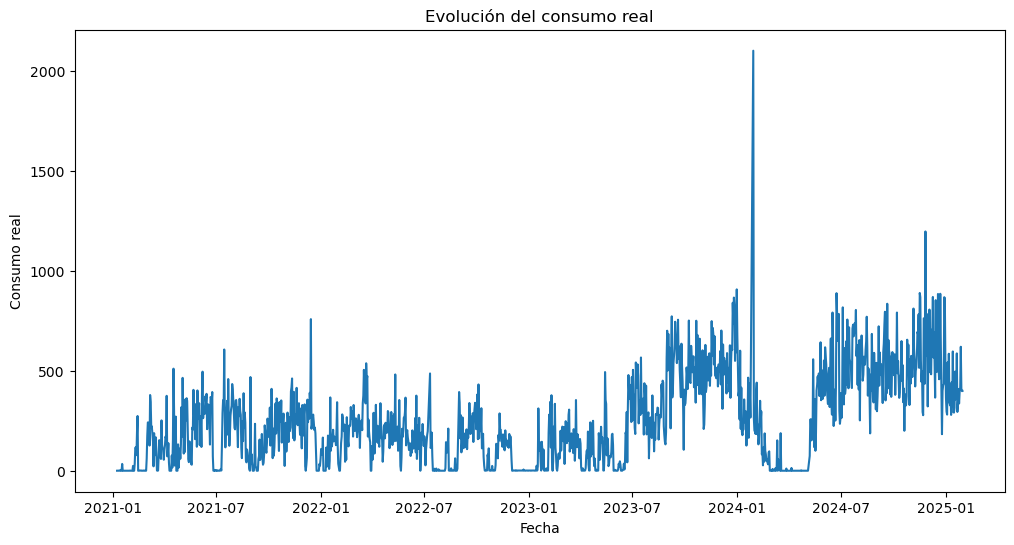

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_poliza, x='FECHA', y='CONSUMO_REAL')
plt.title('Evolución del consumo real')
plt.xlabel('Fecha')
plt.ylabel('Consumo real')
plt.show()

